## Tuning hyperparameters for different ML models

In this notebook, we will use the define-by-run framework to optimize the hyperparameters of various machine learning models from Scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import optuna

In [2]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the objective function

This is the hyperparameter response space, the function we want to optimize.

In [7]:
# the objective function takes the hyperparameter space
# as input

def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["logit", "RF", 'GBM'])
    
    if classifier_name == "logit":
        
        logit_penalty = trial.suggest_categorical('logit_penalty', ['l1','l2'])
        logit_c = trial.suggest_float('logit_c', 0.001, 10)
        logit_solver = 'saga'
        
        model = LogisticRegression(
            penalty=logit_penalty,
            C=logit_c,
            solver=logit_solver,
        )
        
    elif classifier_name =="RF":
        
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 4)
        rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 1)

        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
        )
        
    else:
        
        gbm_n_estimators = trial.suggest_int("gbm_n_estimators", 100, 1000)
        gbm_criterion = trial.suggest_categorical("gbm_criterion", ['squared_error', 'friedman_mse'])
        gbm_max_depth = trial.suggest_int("gbm_max_depth", 1, 4)
        gbm_min_samples_split = trial.suggest_float("gbm_min_samples_split", 0.01, 1)

        model = GradientBoostingClassifier(
            n_estimators=gbm_n_estimators,
            criterion=gbm_criterion,
            max_depth=gbm_max_depth,
            min_samples_split=gbm_min_samples_split,
        )

    
    score = cross_val_score(model, X_train, y_train, cv=3)
    accuracy = score.mean()
    
    return accuracy

## TPE

TPESampler is the default

In [8]:
study = optuna.create_study(
    direction="maximize",
    # we do not need the below line, 
    # tpe is the default search
    sampler=optuna.samplers.TPESampler(),
)


study.optimize(objective, n_trials=20)

[I 2023-09-19 15:17:42,127] A new study created in memory with name: no-name-b0386e3e-cc06-4b42-9690-ed0e513300ca
[I 2023-09-19 15:17:43,765] Trial 0 finished with value: 0.6256360598465861 and parameters: {'classifier': 'RF', 'rf_n_estimators': 574, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 0.7837546092119458}. Best is trial 0 with value: 0.6256360598465861.
[I 2023-09-19 15:17:44,767] Trial 1 finished with value: 0.9647983595352017 and parameters: {'classifier': 'GBM', 'gbm_n_estimators': 207, 'gbm_criterion': 'squared_error', 'gbm_max_depth': 2, 'gbm_min_samples_split': 0.896239181976945}. Best is trial 1 with value: 0.9647983595352017.
[I 2023-09-19 15:17:46,266] Trial 2 finished with value: 0.9597858282068809 and parameters: {'classifier': 'GBM', 'gbm_n_estimators': 231, 'gbm_criterion': 'squared_error', 'gbm_max_depth': 2, 'gbm_min_samples_split': 0.45338762695104406}. Best is trial 1 with value: 0.9647983595352017.
C:\Users\mainn.ho\AppData\Local\Program

In [9]:
study.best_params

{'classifier': 'GBM',
 'gbm_n_estimators': 752,
 'gbm_criterion': 'squared_error',
 'gbm_max_depth': 2,
 'gbm_min_samples_split': 0.9624114913757442}

In [10]:
study.best_value

0.9723551302498671

In [11]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_gbm_criterion,params_gbm_max_depth,params_gbm_min_samples_split,params_gbm_n_estimators,params_logit_c,params_logit_penalty,params_rf_criterion,params_rf_max_depth,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.625636,2023-09-19 15:17:42.128715,2023-09-19 15:17:43.765693,0 days 00:00:01.636978,RF,NaN,NaN,NaN,NaN,NaN,NaN,gini,3.0,0.783755,574.0,COMPLETE
1,1,0.964798,2023-09-19 15:17:43.765693,2023-09-19 15:17:44.767679,0 days 00:00:01.001986,GBM,squared_error,2.0,0.896239,207.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.959786,2023-09-19 15:17:44.768679,2023-09-19 15:17:46.265656,0 days 00:00:01.496977,GBM,squared_error,2.0,0.453388,231.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,0.912015,2023-09-19 15:17:46.268658,2023-09-19 15:17:46.320657,0 days 00:00:00.051999,logit,NaN,NaN,NaN,NaN,4.591130,l2,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.967343,2023-09-19 15:17:46.321657,2023-09-19 15:17:52.416042,0 days 00:00:06.094385,GBM,squared_error,3.0,0.720152,906.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
5,5,0.912015,2023-09-19 15:17:52.417042,2023-09-19 15:17:52.455068,0 days 00:00:00.038026,logit,NaN,NaN,NaN,NaN,7.144857,l2,NaN,NaN,NaN,NaN,COMPLETE
6,6,0.922154,2023-09-19 15:17:52.456072,2023-09-19 15:17:53.639707,0 days 00:00:01.183635,RF,NaN,NaN,NaN,NaN,NaN,NaN,gini,4.0,0.442656,292.0,COMPLETE
7,7,0.912015,2023-09-19 15:17:53.640736,2023-09-19 15:17:53.684707,0 days 00:00:00.043971,logit,NaN,NaN,NaN,NaN,0.153992,l1,NaN,NaN,NaN,NaN,COMPLETE
8,8,0.912015,2023-09-19 15:17:53.685706,2023-09-19 15:17:53.723735,0 days 00:00:00.038029,logit,NaN,NaN,NaN,NaN,5.350498,l2,NaN,NaN,NaN,NaN,COMPLETE
9,9,0.625636,2023-09-19 15:17:53.724734,2023-09-19 15:17:55.647688,0 days 00:00:01.922954,RF,NaN,NaN,NaN,NaN,NaN,NaN,gini,4.0,0.780899,601.0,COMPLETE


In [12]:
results = study.trials_dataframe()

results['params_classifier'].value_counts()

GBM      12
RF        4
logit     4
Name: params_classifier, dtype: int64

The search quickly realised that GBM returned the best performance, so explored the hyperparameter space for that model more than for the others.

In [13]:
results.groupby(['params_classifier'])['value'].agg(['mean', 'std'])

,mean,std
params_classifier,,
GBM,0.965031,0.008109
RF,0.773268,0.170474
logit,0.912015,0.000000


Text(0, 0.5, 'Accuracy')

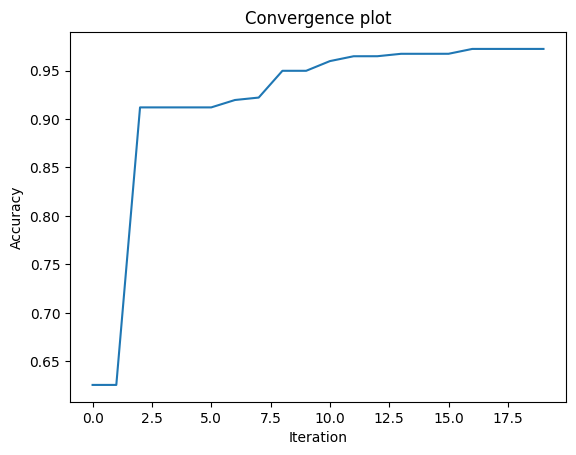

In [14]:
results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')